In [96]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import math
from torch import nn
import torchtext.vocab as vocab

In [97]:
max_seq_len = 120
embedding_dim = 300

PE shape is (120, 300)


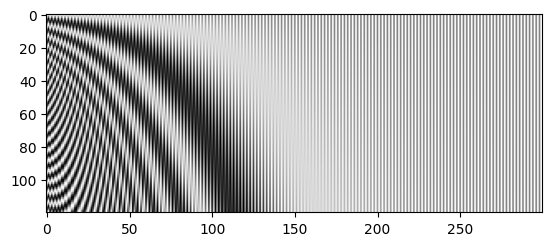

In [98]:
pe = np.array([
    [pos / 10000 ** (2.0 * (i // 2) / embedding_dim) for i in range(embedding_dim)]
 for pos in range(max_seq_len)])
print(f'PE shape is {pe.shape}')

pe[:, 0::2] = np.sin(pe[:, 0::2])
pe[:, 1::2] = np.cos(pe[:, 1::2])
pe_show = cv2.normalize(pe, None, 0, 1, cv2.NORM_MINMAX)
plt.imshow(pe_show, cmap='gray')

In [123]:
# cache_dir是保存golve词典的缓存路径
cache_dir = '.vector_cache/glove'
# dim是embedding的维度
glove = vocab.GloVe(name='6B', dim=embedding_dim, cache=cache_dir) 

sents = [
    'I love apple',
    'I love banana',
    'I love grape',
    'I love cat',
    'I love dog',
    'I love elephant',
]

cls = [0, 0, 0, 1, 1, 1]

word_embedding = []
for s in sents:
    embed = glove.get_vecs_by_tokens(s.split(), True).unsqueeze(0)
    # cls_vec = embed[:, 0:1, :]
    cls_vec = torch.zeros((1, 1, embedding_dim))
    # cls_vec = embed.mean(dim=1).unsqueeze(0)
    embed = torch.concat([cls_vec, embed], dim=1)
    word_embedding.append(embed)


In [124]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12) -> None:
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.bata = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        out = (x - mean) / (std + self.eps)
        out = self.gamma * out + self.bata

        return out


class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim) -> None:
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, d_model),
        )

    def forward(self, x):
        return self.fc(x)


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model) -> None:
        super().__init__()
        self.d_model = d_model
        self.softmax = nn.Softmax(-1)

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor):
        scale = math.sqrt(self.d_model)
        attention = q @ k.swapaxes(1, 2) / scale
        attention = self.softmax(attention)

        context = attention @ v
        return context, attention


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, heads=2) -> None:
        super().__init__()
        self.d_model = d_model
        self.heads = heads
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.linear_c = nn.Linear(d_model, d_model)
        self.scale_dot_product_attention = ScaledDotProductAttention(d_model)

    def forward(self, q, k, v):
        batch_size, num_words, _ = q.shape

        per_head_dim = self.d_model // self.heads
        q = self.linear_q(q)
        k = self.linear_q(k)
        v = self.linear_q(v)

        q = q.reshape(batch_size * self.heads, num_words, per_head_dim)
        k = k.reshape(batch_size * self.heads, num_words, per_head_dim)
        v = v.reshape(batch_size * self.heads, num_words, per_head_dim)

        context, attention = self.scale_dot_product_attention(q, k, v)
        context = context.reshape(batch_size, num_words, self.d_model)
        attention = attention.reshape(batch_size, self.heads, num_words, num_words)

        context = self.linear_c(context)

        return context, attention


class Encoder(nn.Module):
    def __init__(self, d_model, hidden_dim, heads):
        super().__init__()
        self.multihead_attention = MultiHeadAttention(d_model, heads)
        self.layer_norm1 = LayerNorm(d_model)
        self.layer_norm2 = LayerNorm(d_model)
        self.fc = FeedForward(d_model, hidden_dim)
        
    def add_and_norm(self, x, norm):
        return x + norm(x)

    def forward(self, x):
        """
        x.shape = (batch_size, num_words, dim)
        """

        context, attention = self.multihead_attention(x, x, x)
        context = self.add_and_norm(context, self.layer_norm1)
        context = self.fc(context)
        context = self.add_and_norm(context, self.layer_norm2)

        return context, attention
    

from torch.nn import CrossEntropyLoss

class Toy(nn.Module):
    def __init__(self, d_model, hidden_dim, heads) -> None:
        super().__init__()
        self.encoder = Encoder(d_model, hidden_dim, heads)
        self.cls = nn.Linear(d_model, 2)
        self.ce = CrossEntropyLoss()
    
    def get_encoder(self):
        return self.encoder

    def forward(self, embed, label):
        context, attention = self.encoder(embed)
        feat = context[:, 0, :]
        # feat = context.mean(dim=1)
        pred = self.cls(feat)
        loss = self.ce(pred, label)

        return context, attention, pred, loss


def classify(model: Toy, embed, label, opt):
    context, attention, pred, loss = model(embed, label)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    return context, attention, pred, loss


In [146]:
@torch.no_grad()
def show(model, sents, word_embedding, cls):
    model.eval()
    for sent, embed, label in zip(sents, word_embedding, cls):
        label = torch.LongTensor([label])
        context, attention, pred, loss = model(embed, label)
        plt.imshow(attention[0, :, 0].detach().numpy(), cmap='GnBu')
        # plt.yticks([0], labels=['CLS Attention'])
        plt.xticks(range(1 + len(sent.split())), labels=['CLS'] + sent.split())
        # plt.xticks(range(len(sent.split())), labels=sent.split())
        plt.show()
        print(pred, label)
    model.train()

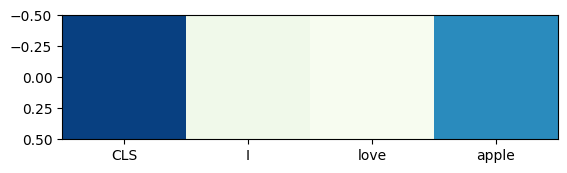

tensor([[ 3.7670, -2.5721]]) tensor([0])


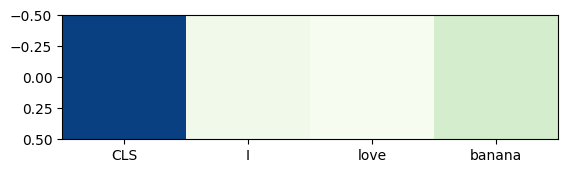

tensor([[ 3.1297, -2.1735]]) tensor([0])


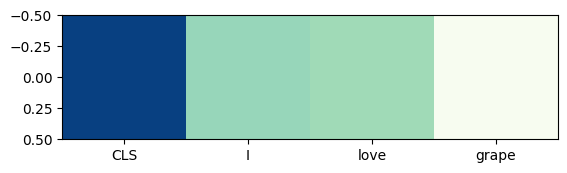

tensor([[ 3.4495, -2.3397]]) tensor([0])


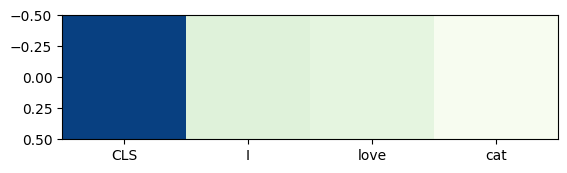

tensor([[ 2.7189, -1.5321]]) tensor([1])


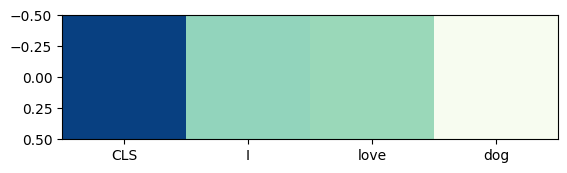

tensor([[ 2.8545, -1.5403]]) tensor([1])


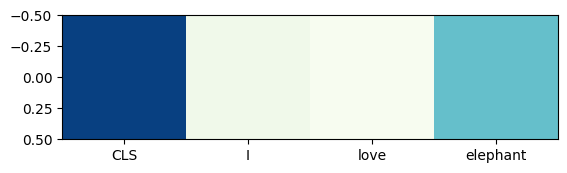

tensor([[ 2.7957, -1.5548]]) tensor([1])


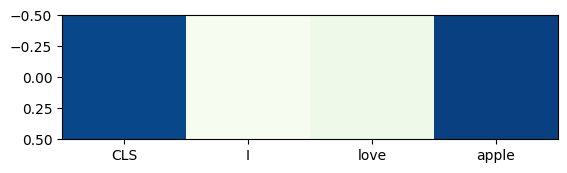

tensor([[ 4.7811, -5.0331]]) tensor([0])


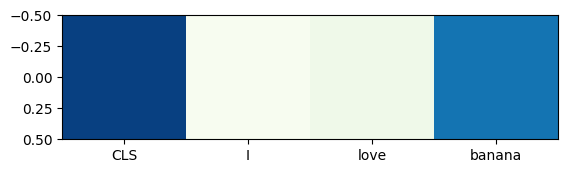

tensor([[ 4.3058, -4.7718]]) tensor([0])


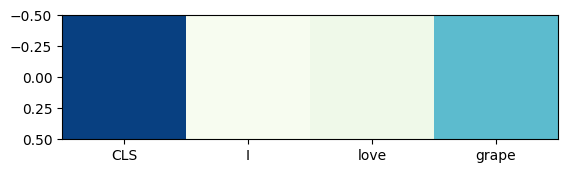

tensor([[ 4.9132, -5.2559]]) tensor([0])


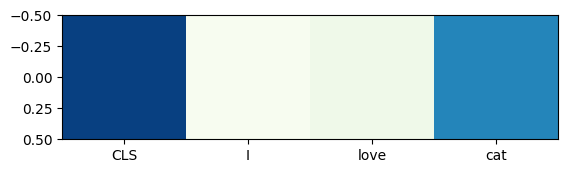

tensor([[-2.7371,  4.3887]]) tensor([1])


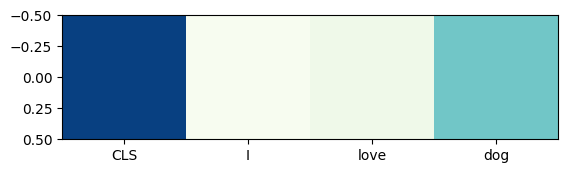

tensor([[-2.7253,  4.6231]]) tensor([1])


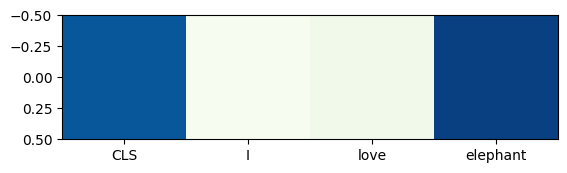

tensor([[-2.7023,  4.4645]]) tensor([1])


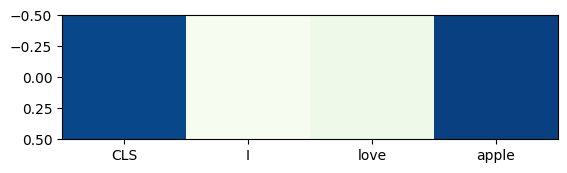

tensor([[ 6.2197, -6.5325]]) tensor([0])


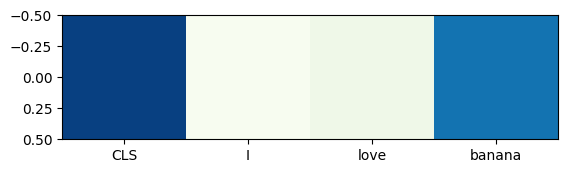

tensor([[ 5.6052, -6.1648]]) tensor([0])


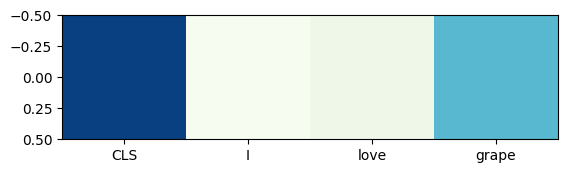

tensor([[ 6.4843, -6.8967]]) tensor([0])


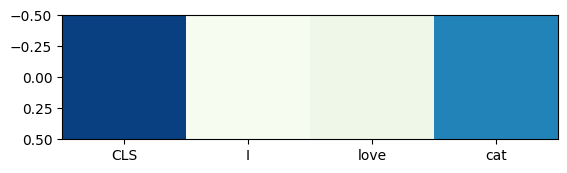

tensor([[-5.1904,  6.8323]]) tensor([1])


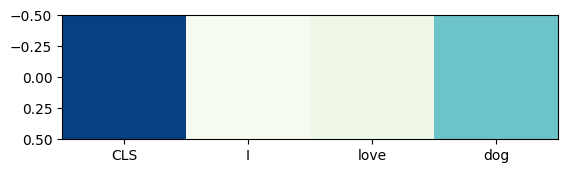

tensor([[-5.1577,  7.0341]]) tensor([1])


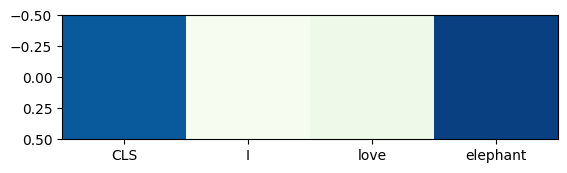

tensor([[-5.0928,  6.8698]]) tensor([1])


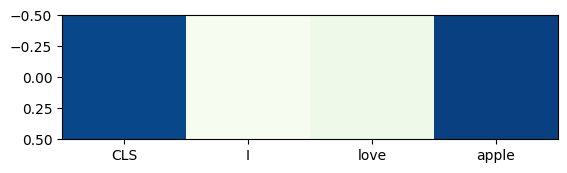

tensor([[ 7.5195, -7.7541]]) tensor([0])


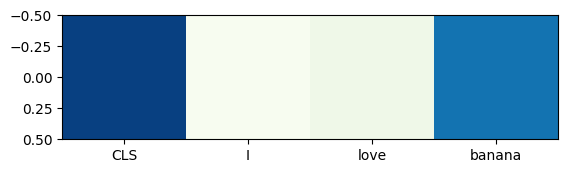

tensor([[ 6.8574, -7.3451]]) tensor([0])


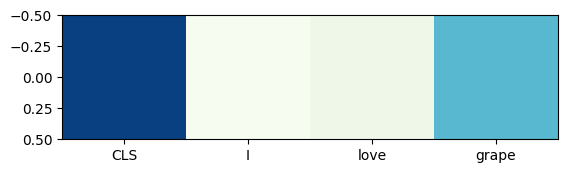

tensor([[ 7.7498, -8.0696]]) tensor([0])


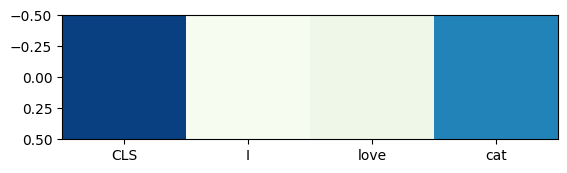

tensor([[-5.8697,  7.5157]]) tensor([1])


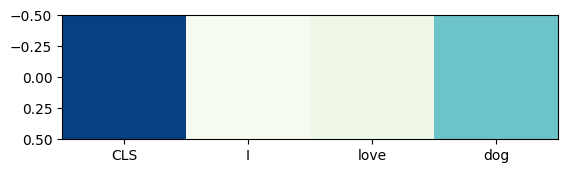

tensor([[-5.8429,  7.7221]]) tensor([1])


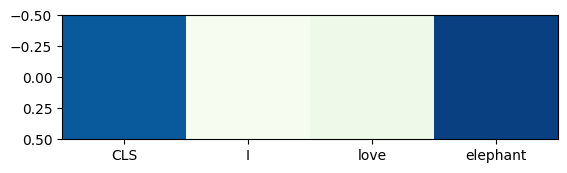

tensor([[-5.7670,  7.5450]]) tensor([1])


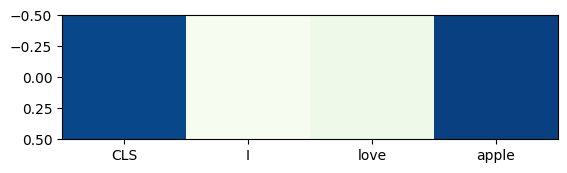

tensor([[ 8.0552, -8.2169]]) tensor([0])


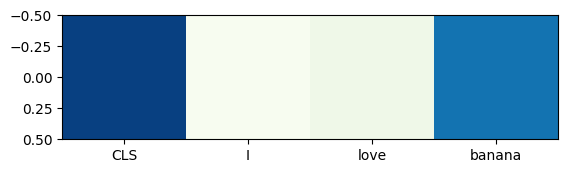

tensor([[ 7.3817, -7.8002]]) tensor([0])


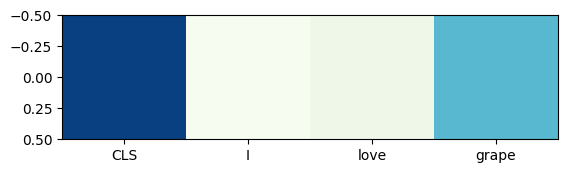

tensor([[ 8.2698, -8.5117]]) tensor([0])


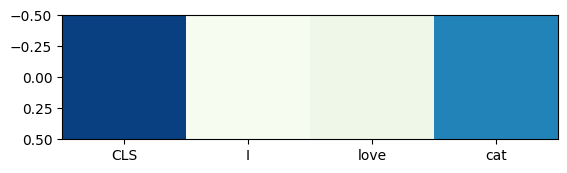

tensor([[-6.2268,  7.8689]]) tensor([1])


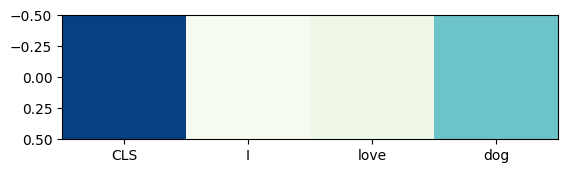

tensor([[-6.2016,  8.0754]]) tensor([1])


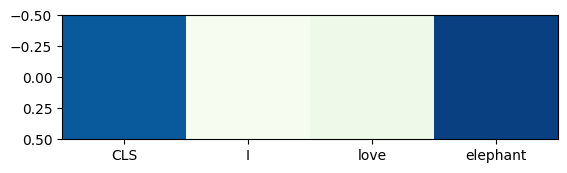

tensor([[-6.1293,  7.8995]]) tensor([1])


In [151]:
from torch.optim import Adam
heads = 1
model = Toy(embedding_dim, embedding_dim * 2, heads)
opt = Adam(model.parameters(), lr=3e-4)
for epoch in range(50):
    for sent, embed, label in zip(sents, word_embedding, cls):
        label = torch.LongTensor([label])
        context, attention, pred, loss = classify(model, embed, label, opt)
    if epoch % 10 == 0:
        show(model, sents, word_embedding, cls)

I love elephant
['I', 'love', 'elephant']


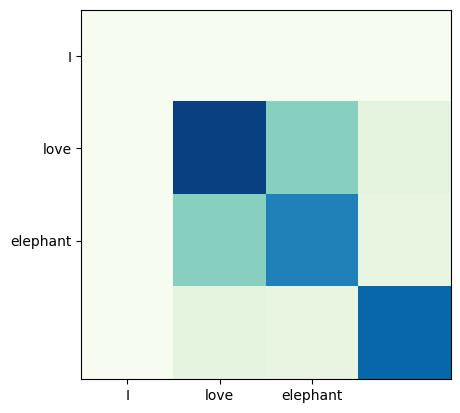

In [152]:
print(sent)
att = embed @ embed.swapaxes(1, 2)
print(sent.split())
plt.xticks(range(len(sent.split())), labels=sent.split())
plt.yticks(range(len(sent.split())), labels=sent.split())
plt.imshow(att[0, :], cmap='GnBu')